# Under-5 Infant Mortality Analysis

## Introduction

My wife and I are expecting a baby in just over three months and with all of our doctor appointments and check up scans I have been very curious about what influences the health of a new baby. This lead me to look at statistics of things like SIDS (Sudden Infant Death Syndrome) and other unexpected ways that children die in their early years. I came across an interesting statistic that was shockingly high in some parts of the world, the mortality rate of Children under 5 years of age. There are countries where this is less than half of a percent and other countries where this is more than 10 percent. I found three features of countries that I think may have an influence on the under-5 mortality rate. The question I want to answer is if I can predict whether the under-5 mortality rate of children is low, moderate, or severe using GDP per capita, population, and the countries life expectancy.

## Collecting and Cleaning the Data

I was able to find data for the mortality rate, GDP per capita, and population from Wikipedia pages. I scraped the data from those tables and this left me only needing life expectancy data by country. I was able to find a public data set with this information.

In [95]:
# Import Libraries
import pandas as pd
pd.options.mode.chained_assignment = None # Won't produce a warning when using chained assignment
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
mortality_rate_url = "https://en.wikipedia.org/wiki/List_of_countries_by_infant_and_under-five_mortality_rates"
GDP_per_capita_url = "https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(PPP)_per_capita"
population_url = "https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population"

In [3]:
mortality_page = pd.read_html(mortality_rate_url)

In [4]:
mortality_data = mortality_page[2][["Country or territory", "2019mortality rate,under-5(per 1000live births)"]]
mortality_data.columns = ["country", "under-5 mortality per 1000 births"]

In [142]:
mortality_data.head(2)

,country,under-5 mortality per 1000 births
0,Afghanistan,60.3
1,Albania,9.7


In [6]:
GDP_per_capita_page = pd.read_html(GDP_per_capita_url)

In [7]:
GDP_per_capita_data = GDP_per_capita_page[3][["Country/Territory", "Int$"]]
GDP_per_capita_data.columns = ["country", "gdp per cap"]

In [8]:
GDP_per_capita_data.head(2)

,country,gdp per cap
0,Macau,129103
1,Luxembourg,121293


In [9]:
population_page = pd.read_html(population_url)

In [10]:
population_data = population_page[0][["Country(or dependent territory)", "Population"]]
population_data.columns = ["country", "population"]

In [11]:
population_data["country"] = population_data.country.apply(lambda x: re.sub(r"\[\S+", "", x).strip()).apply(lambda y: re.sub(r"\(\S+", "", y))

In [12]:
population_data.head(2)

,country,population
0,China,1405689200
1,India,1370682276


In [13]:
life_expectancy_data = pd.read_csv("API_SP.DYN.LE00.IN_DS2_en_csv_v2_1740384.csv")

In [14]:
life_expectancy_data = life_expectancy_data[["Country Name", "2018"]]
life_expectancy_data.columns = ["country", "life expectancy"]
life_expectancy_data = life_expectancy_data.dropna()

In [15]:
life_expectancy_data.head(2)

,country,life expectancy
0,Aruba,76.152
1,Afghanistan,64.486


One of the difficult parts was getting the country names to match across all four data sets. So I was able to find the names that did not match and make those edits

In [16]:
mortality_data['country'][mortality_data['country'] == 'Congo, Democratic Republic of the'] = 'Dem. Congo'
mortality_data['country'][mortality_data['country'] == 'Congo, Republic of the'] = 'Rep. Congo'
mortality_data['country'][mortality_data['country'] == 'Korea, North'] = 'North Korea'
mortality_data['country'][mortality_data['country'] == 'Korea, South'] = 'South Korea'
mortality_data['country'][mortality_data['country'] == 'Micronesia, Federated States of'] = 'Micronesia'
mortality_data['country'][mortality_data['country'] == 'Eswatini (Swaziland)'] = 'Eswatini'

In [17]:
life_expectancy_data['country'][life_expectancy_data['country'] == 'Brunei Darussalam'] = 'Brunei'
life_expectancy_data['country'][life_expectancy_data['country'] == 'Cabo Verde'] = 'Cape Verde'
life_expectancy_data['country'][life_expectancy_data['country'] == 'Congo, Dem. Rep.'] = 'Dem. Congo'
life_expectancy_data['country'][life_expectancy_data['country'] == 'Congo, Rep.'] = 'Rep. Congo'
life_expectancy_data['country'][life_expectancy_data['country'] == 'Egypt, Arab Rep.'] = 'Egypt'
life_expectancy_data['country'][life_expectancy_data['country'] == 'Iran, Islamic Rep.'] = 'Iran'
life_expectancy_data['country'][life_expectancy_data['country'] == 'Kyrgyz Republic'] = 'Kyrgyzstan'
life_expectancy_data['country'][life_expectancy_data['country'] == 'Lao PDR'] = 'Laos'
life_expectancy_data['country'][life_expectancy_data['country'] == 'Micronesia, Fed. Sts.'] = 'Micronesia'
life_expectancy_data['country'][life_expectancy_data['country'] == 'Korea, Rep.'] = 'North Korea'
life_expectancy_data['country'][life_expectancy_data['country'] == 'Russian Federation'] = 'Russia'
life_expectancy_data['country'][life_expectancy_data['country'] == 'Slovak Republic'] = 'Slovakia'
life_expectancy_data['country'][life_expectancy_data['country'] == 'St. Kitts and Nevis'] = 'Saint Kitts and Nevis'
life_expectancy_data['country'][life_expectancy_data['country'] == 'St. Vincent and the Grenadines'] = 'Saint Vincent and the Grenadines'
life_expectancy_data['country'][life_expectancy_data['country'] == 'St. Lucia'] = 'Saint Lucia'
life_expectancy_data['country'][life_expectancy_data['country'] == 'Korea, Dem. People’s Rep.'] = 'South Korea'
life_expectancy_data['country'][life_expectancy_data['country'] == 'Syrian Arab Republic'] = 'Syria'
life_expectancy_data['country'][life_expectancy_data['country'] == 'Venezuela, RB'] = 'Venezuela'
life_expectancy_data['country'][life_expectancy_data['country'] == 'West Bank and Gaza'] = 'West Bank'
life_expectancy_data['country'][life_expectancy_data['country'] == 'Yemen, Rep.'] = 'Yemen'

In [18]:
np.setdiff1d(list(mortality_data.country), list(life_expectancy_data.country))

array(['Andorra', 'Dominica', 'Marshall Islands', 'Monaco', 'Nauru',
       'Palau', 'Saint Kitts and Nevis', 'San Marino', 'Tuvalu'],
      dtype='<U32')

In [19]:
# np.setdiff1d(list(life_expectancy_data.country), list(mortality_data.country))

In [20]:
GDP_per_capita_data['country'][GDP_per_capita_data['country'] == 'Côte d\'Ivoire'] = 'Cote d\'Ivoire'
GDP_per_capita_data['country'][GDP_per_capita_data['country'] == 'Democratic Republic of the Congo'] = 'Dem. Congo'
GDP_per_capita_data['country'][GDP_per_capita_data['country'] == 'The Gambia'] = 'Gambia, The'
GDP_per_capita_data['country'][GDP_per_capita_data['country'] == 'Iran (2017)'] = 'Iran'
GDP_per_capita_data['country'][GDP_per_capita_data['country'] == 'The Bahamas'] = 'Bahamas, The'
GDP_per_capita_data['country'][GDP_per_capita_data['country'] == 'Federated States of Micronesia'] = 'Micronesia'
GDP_per_capita_data['country'][GDP_per_capita_data['country'] == 'Republic of the Congo'] = 'Rep. Congo'
GDP_per_capita_data['country'][GDP_per_capita_data['country'] == 'San Marino (2018)'] = 'San Marino'
GDP_per_capita_data['country'][GDP_per_capita_data['country'] == 'São Tomé and Príncipe'] = 'Sao Tome and Principe'
GDP_per_capita_data['country'][GDP_per_capita_data['country'] == 'South Sudan (2014)'] = 'South Sudan'
GDP_per_capita_data['country'][GDP_per_capita_data['country'] == 'Venezuela (2011)'] = 'Venezuela'
GDP_per_capita_data['country'][GDP_per_capita_data['country'] == 'West Bank and Gaza (2018)'] = 'West Bank'
GDP_per_capita_data['country'][GDP_per_capita_data['country'] == 'Yemen (2013)'] = 'Yemen'

In [21]:
np.setdiff1d(list(mortality_data.country), list(GDP_per_capita_data.country))

array(['Andorra', 'Cuba', 'Eritrea', 'Monaco', 'North Korea', 'Somalia',
       'Syria'], dtype='<U32')

In [22]:
# np.setdiff1d(list(GDP_per_capita_data.country), list(mortality_data.country))

In [23]:
population_data['country'][population_data['country'] == 'Bahamas'] = 'Bahamas, The'
population_data['country'][population_data['country'] == 'Congo'] = 'Dem. Congo'
population_data['country'][population_data['country'] == 'Gambia'] = 'Gambia, The'
population_data['country'][population_data['country'] == 'F.S. Micronesia'] = 'Micronesia'
population_data['country'][population_data['country'] == 'São Tomé and Príncipe'] = 'Sao Tome and Principe'

In [24]:
np.setdiff1d(list(mortality_data.country), list(population_data.country))

array(["Cote d'Ivoire", 'Rep. Congo', 'Timor-Leste', 'West Bank'],
      dtype='<U32')

In [25]:
# np.setdiff1d(list(population_data.country), list(mortality_data.country))

After I got the country names to match I was ready to compile all of the data into one data frame I did this by creating separate functions that pulled the metric I was looking for from the data frame where it was stored.

In [26]:
# Create the data frame
data = pd.DataFrame()

In [27]:
data['country'] = mortality_data['country']
data['mortality'] = mortality_data['under-5 mortality per 1000 births']

In [28]:
def FillPopulation(x):
    if (len(population_data['population'][population_data['country'] == x]) == 1):
        return population_data['population'][population_data['country'] == x]
    else :
        return float('NaN')

In [29]:
data["population"] = -1

In [30]:
for i in range(len(data)):
    data['population'][i] = FillPopulation(data['country'][i])

In [31]:
def FillLifeExpectancy(x):
    if (len(life_expectancy_data['life expectancy'][life_expectancy_data['country'] == x]) == 1):
        return life_expectancy_data['life expectancy'][life_expectancy_data['country'] == x]
    else :
        return float('NaN')

In [32]:
data["life expectancy"] = -1

In [33]:
for i in range(len(data)):
    data['life expectancy'][i] = FillLifeExpectancy(data['country'][i])

In [34]:
def FillGdpPerCapita(x):
    if (len(GDP_per_capita_data['gdp per cap'][GDP_per_capita_data['country'] == x]) == 1):
        return GDP_per_capita_data['gdp per cap'][GDP_per_capita_data['country'] == x]
    else :
        return float('NaN')

In [35]:
data["gdp per cap"] = -1

In [36]:
for i in range(len(data)):
    data['gdp per cap'][i] = FillGdpPerCapita(data['country'][i])

## EDA

Below I removed the rows with missing data points as well as removed a few outliers. I did a log transformation on GDP per capita and population. I also separated the countries into three groups, low, moderate, and severe under-5 mortality rates for children.

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          193 non-null    object 
 1   mortality        193 non-null    float64
 2   population       189 non-null    float64
 3   life expectancy  184 non-null    float64
 4   gdp per cap      186 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.7+ KB


In [38]:
data = data.dropna()

In [39]:
data.head()

,country,mortality,population,life expectancy,gdp per cap
0,Afghanistan,60.3,32890171.0,64.000,2293.0
1,Albania,9.7,2845955.0,78.000,14495.0
2,Algeria,23.3,43900000.0,76.000,11820.0
4,Angola,74.7,31127674.0,60.782,6929.0
5,Antigua and Barbuda,6.6,97895.0,76.885,22817.0


Below are three plots that compare mortality to the three features in my data set. After that is a table of the correlations. We see that the strongest correlation is between Life Expectancy and mortality

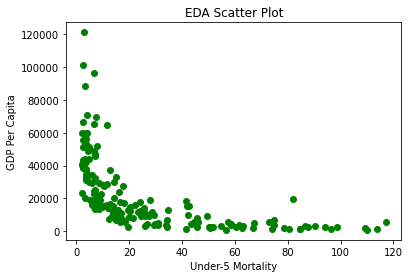

In [40]:
plt.scatter(data.mortality, data["gdp per cap"], c = "green")
plt.xlabel("Under-5 Mortality")
plt.ylabel("GDP Per Capita")
plt.title("EDA Scatter Plot")
plt.show()

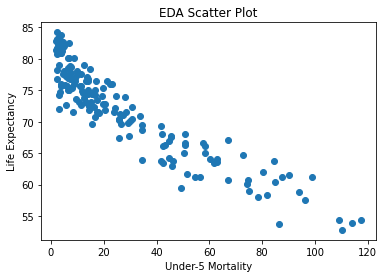

In [41]:
plt.scatter(data.mortality, data["life expectancy"])
plt.xlabel("Under-5 Mortality")
plt.ylabel("Life Expectancy")
plt.title("EDA Scatter Plot")
plt.show()

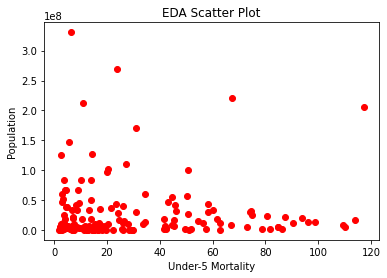

In [42]:
# I had to remove China and India from the data for this plot because they were such extreme population outliers.
plt.scatter(data.mortality[(data['country'] != "China") & (data['country'] != "India")], data["population"][(data['country'] != "China") & (data['country'] != "India")], c = "red")
plt.xlabel("Under-5 Mortality")
plt.ylabel("Population")
plt.title("EDA Scatter Plot")
plt.show()

In [43]:
data.corr()

,mortality,population,life expectancy,gdp per cap
mortality,1.000000,-0.012973,-0.918604,-0.588327
population,-0.012973,1.000000,0.011672,-0.046980
life expectancy,-0.918604,0.011672,1.000000,0.706349
gdp per cap,-0.588327,-0.046980,0.706349,1.000000


In [45]:
data.mortality.min()

2.0

In [49]:
np.percentile(data.mortality, [25, 33, 50, 66, 75])

array([ 6.6  ,  8.484, 15.6  , 27.188, 42.45 ])

In [48]:
data.mortality.max()

117.2

I'll make three clusters to represent low, moderate, and severe mortality rates with 0-10, 10-30, and above 30 deaths per 1000 infants respectively.

In [64]:
def assign(x):
    if (x < 10):
        return 0
    elif (x < 30):
        return 1
    else:
        return 2

In [65]:
data['label'] = data.mortality.apply(lambda x: assign(x))

In [66]:
data.head()

,country,mortality,population,life expectancy,gdp per cap,label
0,Afghanistan,60.3,32890171.0,64.000,2293.0,2
1,Albania,9.7,2845955.0,78.000,14495.0,0
2,Algeria,23.3,43900000.0,76.000,11820.0,1
4,Angola,74.7,31127674.0,60.782,6929.0,2
5,Antigua and Barbuda,6.6,97895.0,76.885,22817.0,0


I decided to remove China and India due to their population being such outliers. I also decided to take a log transformation of population and gdp per capita

In [76]:
data = data[(data['country'] != "China") & (data['country'] != "India")]

In [85]:
data['population'] = data['population'].apply(lambda x: np.log(x))

In [86]:
data['gdp per cap'] = data['gdp per cap'].apply(lambda x: np.log(x))

As part of my EDA I clustered the data with no labels. I was able to look at which features pulled the strongest I also scaled my data for the duration of the analysis from 0-1 for each feature.

In [87]:
scalar = MinMaxScaler()

In [88]:
scalar.fit(data[['mortality', 'population', "life expectancy", "gdp per cap"]])

MinMaxScaler()

In [89]:
X = scalar.transform(data[['mortality', 'population', "life expectancy", "gdp per cap"]])

In [91]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

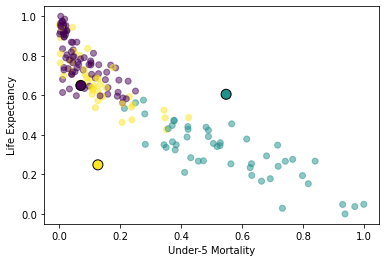

In [92]:
plt.scatter(X[:,0], X[:,2], c=y_kmeans, cmap='viridis',alpha=.5)
plt.ylabel("Life Expectancy")
plt.xlabel("Under-5 Mortality")
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c=np.arange(0,3),cmap='viridis', s=100,edgecolors='black')
plt.show()

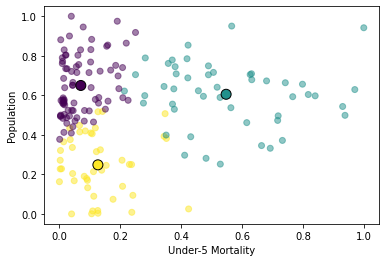

In [93]:
plt.scatter(X[:,0], X[:,1], c=y_kmeans, cmap='viridis',alpha=.5)
plt.xlabel("Under-5 Mortality")
plt.ylabel("Population")
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c=np.arange(0,3),cmap='viridis', s=100,edgecolors='black')
plt.show()

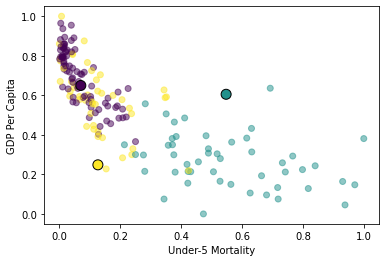

In [94]:
plt.scatter(X[:,0], X[:,3], c=y_kmeans, cmap='viridis',alpha=.5)
plt.xlabel("Under-5 Mortality")
plt.ylabel("GDP Per Capita")
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c=np.arange(0,3),cmap='viridis', s=100,edgecolors='black')
plt.show()

## Modeling

In [138]:
# Import models and metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import average_precision_score

In [105]:
X = data[["population", "life expectancy", "gdp per cap"]]
Y = data["label"]

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 426, test_size = 0.25)

In [107]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Suppprt Vector Classifier, this model preformed very well.

In [118]:
svclassifier = SVC()
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
print("Training Accuracy:", svclassifier.score(X_train, y_train)) #Accuracy of the model when training
print("Testing Accuracy:", svclassifier.score(X_test, y_test)) #Accuracy of the test
print("F1 Score:", f1_score(y_pred, y_test, average="weighted")) #F1 score

Training Accuracy: 0.9147286821705426
Testing Accuracy: 0.8636363636363636
F1 Score: 0.8652597402597402


Random Forrest Classifier, this model performed well but over fit the training set. It is still a good model however. Possibly could have been more successful with tuning the hyper parameters. However it did not perform well enough to continue to try and improve it.

In [119]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Training Accuracy:", rf.score(X_train, y_train)) #Accuracy of the model when training
print("Testing Accuracy:", rf.score(X_test, y_test)) #Accuracy of the test
print("F1 Score:", f1_score(y_pred, y_test, average="weighted")) #F1 score

Training Accuracy: 1.0
Testing Accuracy: 0.8409090909090909
F1 Score: 0.8438697318007663


Logistic Regression, this model performed well but I believe it would have performed better with more features.

In [121]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Training Accuracy:", lr.score(X_train, y_train)) #Accuracy of the model when training
print("Testing Accuracy:", lr.score(X_test, y_test)) #Accuracy of the test
print("F1 Score:", f1_score(y_pred, y_test, average="weighted")) #F1 score

Training Accuracy: 0.8449612403100775
Testing Accuracy: 0.8181818181818182
F1 Score: 0.8277348262685507


Ada Boost Classifier, this model preformed the worst out of all of the models I selected. It may have put too much emphasis on one feature or another that led to poor metrics.

In [124]:
boost = AdaBoostClassifier()
boost.fit(X_train, y_train)
y_pred = boost.predict(X_test)
print("Training Accuracy:", boost.score(X_train, y_train)) #Accuracy of the model when training
print("Testing Accuracy:", boost.score(X_test, y_test)) #Accuracy of the test
print("F1 Score:", f1_score(y_pred, y_test, average="weighted")) #F1 score

Training Accuracy: 0.627906976744186
Testing Accuracy: 0.6136363636363636
F1 Score: 0.7165796723212992


Gaussian Naive Bayes Model, this model had very good metrics. I did try and tune the hyper parameters with a grid search cross validation but the metrics I am using went down. This does not mean that the model got worse only that it did not improve the metrics I am tracking.

In [140]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Training Accuracy:", nb.score(X_train, y_train)) #Accuracy of the model when training
print("Testing Accuracy:", nb.score(X_test, y_test)) #Accuracy of the test
print("F1 Score:", f1_score(y_pred, y_test, average="weighted")) #F1 score

Training Accuracy: 0.8682170542635659
Testing Accuracy: 0.8863636363636364
F1 Score: 0.8890856618129345


I decided to use test and train accuracy as well as F1 Score to evaluate my models. I felt good about using accuracy because the number of countries in each of the three groups is relatively equal. Accuracy can sometimes be a missleading metric such as in the Random Forrest Model where the training data was overfit. F1 Score is a very good metric to use with multiclass classification. It is a function of Precision and Recall and so it is a good umbrella metric. It helps us see how strong out model is in predicting.

## Results

I used five different models on my data all of which tend to be successful with multiclass classification. Some unique things about my data where that some features were more important than others. We saw that life expectancy had a stronger correlation with infant mortality than did population. In addition to this all of my metrics were numeric. This gave some models an advantage where other models came in weak. The Gaussian Naive Bayes was the best model. On the testing data set it predicted 88.6% of countries in the correct cluster and had a very strong F1 score of .89 which tells us that is it predicting accurately based on the precision and recall. To answer our research question we found that we can predict whether infant mortality in a country is low, moderate, or severe based on population, GDP per capita, and life expectancy.

## Conclusion

As My wife and I get closer to meeting our daughter I can rest assured knowing that there is a very low chance (.6%) of our child not making it to the age of 5 since we live in the United States. People in some countries of Africa are looking at over 10% however. From my study I found that if the country has a higher life expectancy then the mortality rate goes down. We can imply that this could be due to access to medical care and technology. We also found the second important is the GDP per capita. When countries produce more money there is a good chance that the under-5 mortality rate is lower. GDP per capita is not as important of a feature as life expectancy but is more telling than population. Population turned out to be the least informative and there was little predictive power in identifying under-5 mortality rate.

In this study there could be many other variables that we are not accounting for. It is also true that the correlation between life expectancy and mortality rate is due to medical advancements, for example. A future study could be to look more into variables such as access to medical attention or even geographical/climatic variables.